# Receiver-side:Fast Fourier Transform based Spectrum Analysis

Fast Fourier Transform (FFT) based spectrum analysis is a fundamental technique used across various disciplines for analyzing signals in the frequency domain. Here's a more detailed breakdown of how FFT-based spectrum analysis works and its applications:

1. **Signal Acquisition**:
In any system where FFT-based spectrum analysis is applied, the first step involves acquiring a time-domain signal. This signal could originate from sensors, antennas, communication receivers, audio devices, or any other source that produces a continuous-time waveform.

2. **Sampling:
The continuous-time signal is then sampled at discrete intervals, converting it into a sequence of digital samples. The sampling process involves measuring the amplitude of the signal at regular time intervals, typically governed by the Nyquist-Shannon sampling theorem to ensure faithful representation of the original signal.

3. **Windowing (Optional)**:
Prior to applying the FFT, a windowing function may be applied to the sampled signal. Windowing functions serve to reduce spectral leakage, which occurs when the frequency components of a signal extend beyond the boundaries of the sampled data. Common windowing functions include the Hamming, Hanning, and Blackman-Harris windows.

4. **FFT Computation**:
The heart of FFT-based spectrum analysis lies in the computation of the Fast Fourier Transform. The FFT algorithm efficiently computes the discrete Fourier transform (DFT) of the sampled signal. By decomposing the time-domain signal into its frequency components, the FFT provides a representation of the signal's spectral content.

5. **Frequency Bin Selection**:
The output of the FFT is a frequency-domain representation of the signal, typically organized into frequency bins. Each frequency bin corresponds to a specific range of frequencies. The magnitude or power of each frequency bin indicates the strength of the signal component at that frequency.

6. **Spectrum Analysis**:
The resulting spectrum provides valuable insights into the frequency characteristics of the signal. By analyzing the spectrum, engineers and researchers can:

    - Identify dominant frequency components and harmonic content.
    - Detect and analyze signals of interest, such as communication signals or biomedical signals.
    - Characterize noise and interference in the signal.
    - Perform modulation recognition and demodulation.
    - Estimate channel frequency responses in communication systems.
    - Monitor spectral occupancy in spectrum sensing applications.
    
FFT-based spectrum analysis is used across a wide range of fields, including telecommunications, audio engineering, radar systems, medical imaging, and scientific research. Its efficiency, speed, and versatility make it an indispensable tool for understanding and analyzing signals in the frequency domain.







## 2.2 Import libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

import numpy as np
import adi


## 2.2 System Parameters

In [2]:

fftSize           = 2**10         # fft-size
subcarrierSpacing = 10**3     # subcarrier spacing
sampleRate        = fftSize*subcarrierSpacing
carrierFrequency  = 10**9 # Hz
numSamples        = fftSize*2 # number of samples per call to rx()


## 2.2 Setup SDRs

In [3]:

sdr             = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(sampleRate)

# # Config Tx
# sdr.tx_rf_bandwidth         = int(sampleRate) # filter cutoff, just set it to the same as sample rate
# sdr.tx_lo                   = int(carrierFrequency)
# sdr.tx_hardwaregain_chan0   = -20 # Increase to increase tx power, valid range is -90 to 0 dB

# Config Rx
sdr.rx_lo                   = int(carrierFrequency)
sdr.rx_rf_bandwidth         = int(sampleRate)
sdr.rx_buffer_size          = 16*numSamples
sdr.gain_control_mode_chan0 = 'slow_attack'
# sdr.rx_hardwaregain_chan0   = 30.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC


## 2.2 Receiver Side

### 2.2 Signal Acquisition: Receive the samples

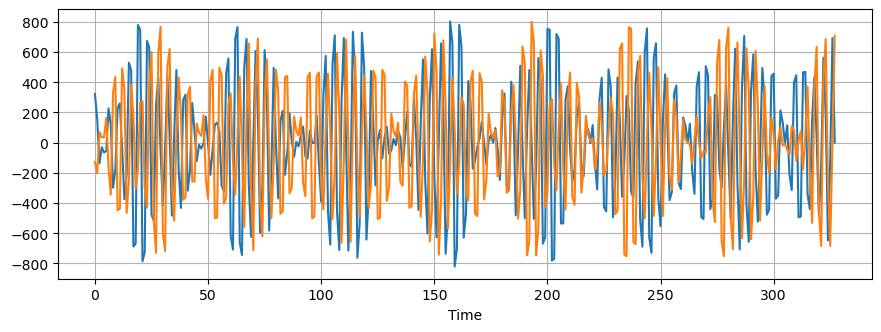

In [4]:

# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

# Receive samples
rx_samples = sdr.rx()


# Plot time domain
fig, ax = plt.subplots(figsize=(10.5,3.5))
ax.plot(np.real(rx_samples[::100]))
ax.plot(np.imag(rx_samples[::100]))
ax.set_xlabel("Time")
ax.grid()
plt.show()


## 2.2 Spectrum Computation

### 2.2 Compute the power spectral density

- Rectangular Window of size: ``Nfft``
- FFT: Transform signal from time to frequency
- Compute power spectrum density.

In [5]:

# Calculate power spectral density (frequency domain version of signal)
psdr    = np.abs(np.fft.fft(rx_samples.reshape(fftSize, -1), fftSize, axis=0, norm="ortho"))**2
psd_dBr = 10*np.log10(psdr)


### 2.2 Display the power spectral density 

In [6]:
# Plot freq domain

fig, ax = plt.subplots(figsize=(10.5,3.5))
ax.plot(psd_dBr[:,0])
ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("Power Spectral Density (dB)")
ax.grid()
plt.show()


## 2.2 Quasi Real-time Spectrum Analysis

![caustion-2.2](caution.jpg) **Please ensure that you have intractive matplotlib installed on your system and uncomment the ``%matplotlib widget`` in first code block for the following section of code to work**

In [7]:
# function that draws each frame of the animation
freq    = np.linspace(-fftSize*subcarrierSpacing, fftSize*subcarrierSpacing, fftSize)/10**6

def animate(i):

    rx_samples = sdr.rx()

    psdr    = np.abs(np.fft.fftshift(np.fft.fft(rx_samples.reshape(fftSize, -1), fftSize, axis=0, norm="ortho")))**2
    psd_dBr = 10*np.log10(psdr)

    ax[0].clear()
    ax[0].grid()
    ax[0].set_yticks(np.arange(0,100,20))
    ax[0].set_ylim([5, 90])
    ax[0].set_xlim([freq[0]*1.05, freq[-1]*1.05])
#     ax[0].plot(psd_dBr[:,0], color='crimson')
    ax[0].plot(freq, (psd_dBr).mean(-1))


    ax[0].set_xlabel('Freq (sec)')
    ax[0].set_ylabel('Received-Power (dB)')
    ax[0].set_title('Power Spectrum', fontsize=12)
#     ax[0].set_ylim([0,85])
#     ax[0].legend()

    ax[1].clear()
    ax[1].grid()
    ax[1].set_ylim([-1000, 1000])
    ax[1].plot(np.real(rx_samples[0:fftSize]), label = "Real part")
    ax[1].plot(np.imag(rx_samples[0:fftSize]), label = "Imaginary part")

    ax[1].set_xlabel("Time")
    ax[1].set_ylabel('Received signal')
    ax[1].set_title('Received signal vs Time', fontsize=12)
    ax[1].legend()



# create the figure and axes objects
scaleFig = 1.75
fig, ax  = plt.subplots(2,1,figsize=(20/scaleFig, 15/scaleFig))
fig.suptitle('Spectrum of the Received Signal', fontsize=10)


#####################
# run the animation
#####################
# frames= 20 means 20 times the animation function is called.
# interval=500 means 500 milliseconds between each frame.
# repeat=False means that after all the frames are drawn, the animation will not repeat.
# Note: plt.show() line is always called after the FuncAnimation line.


anim = animation.FuncAnimation(fig, animate, frames=100, interval=1, repeat=False, blit=True)
# saving to mp4 using ffmpeg writer
# writervideo = animation.FFMpegWriter(fps=30)
# anim.save('SimulationOfNodeMobility.mp4', writer=writervideo)
# anim.save('SimulationOfNodeMobility.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
anim.save("mobility.gif", fps = 2)
plt.show()

![display-2.2](mobility2.gif)